In [1]:
import logging
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# disable scikit-learn warnings
logger = logging.getLogger('sklearn')
logger.setLevel(logging.ERROR)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import cv2

url = 'http://minio-api.kubby.ninja/fix-dive-storage/projects/1234567890/features/features/features.gzip.parquet'
#url = 'http://minio-api.kubby.ninja/fix-dive-storage/projects/1234567890/features/preprocess/preprocess.gzip.parquet'

df = pd.read_parquet(url)

# filter out all nan values
df = df.dropna()

df = df[df['features'].notnull()]
df['features'] = df['features'].apply(lambda x: np.frombuffer(x, dtype=np.float32))

# group every 5 seconds (5 * 60 = 300)
df['group'] = df['frame_index'].apply(lambda x: int(x / 300))

df

,frame_index,features,group
4,4.0,"[0.012614815, 0.115511544, 0.20214368, 0.0, 0....",0
9,9.0,"[0.69694954, 0.0987587, 0.22006409, 0.0, 0.720...",0
14,14.0,"[0.07226824, 0.18683071, 0.20187503, 0.0088139...",0
19,19.0,"[0.032076776, 0.3108524, 0.07054333, 0.0019203...",0
24,24.0,"[0.53778356, 0.8560783, 0.05249295, 0.0, 0.720...",0
...,...,...,...
4031,4031.0,"[0.0, 0.45996606, 0.36335358, 0.0, 1.1535114, ...",13
4036,4036.0,"[0.0, 0.34590313, 2.2383053, 0.022731684, 1.73...",13
4041,4041.0,"[0.012310203, 0.17214078, 1.5623567, 0.0130757...",13
4046,4046.0,"[0.023814026, 0.23032632, 1.3267161, 0.0, 2.05...",13


In [4]:
from scipy.ndimage.filters import gaussian_filter
from matplotlib import cm

def kmeans_inertia(scaled_data, k, alpha_k=0.02):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def best_kmeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kmeans_inertia(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results


def convert_to_heatmap(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


def cluster(subdf):
    features = subdf['features'] # (60, 2048)
    x = np.concatenate(features.values, axis=0).reshape(-1, 2048)
    
    #features = subdf[[c for c in subdf.columns if c not in ['frame_index', 'group']]]
    #x = features.values
    
    scaler = Pipeline([
        ('scale', MinMaxScaler()),
        #('pca', PCA(n_components=10))
    ])
    
    xt = scaler.fit_transform(x)
    best_k, _ = best_kmeans(xt, range(2, 10))

    model = KMeans(n_clusters=best_k)
    model.fit(xt)
    subdf['cluster'] = model.labels_
    subdf['xtx'] = xt[:, 0]
    subdf['xty'] = xt[:, 1]
    
    return subdf

/tmp/ipykernel_17956/42673491.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [5]:
groups = df.groupby('group').apply(cluster)

In [7]:
groups

,frame_index,features,group,cluster,xtx,xty
4,4.0,"[0.012614815, 0.115511544, 0.20214368, 0.0, 0....",0,8,0.000000,0.084786
9,9.0,"[0.69694954, 0.0987587, 0.22006409, 0.0, 0.720...",0,8,0.267855,0.072490
14,14.0,"[0.07226824, 0.18683071, 0.20187503, 0.0088139...",0,8,0.023349,0.137135
19,19.0,"[0.032076776, 0.3108524, 0.07054333, 0.0019203...",0,8,0.007618,0.228168
24,24.0,"[0.53778356, 0.8560783, 0.05249295, 0.0, 0.720...",0,8,0.205556,0.628368
...,...,...,...,...,...,...
4031,4031.0,"[0.0, 0.45996606, 0.36335358, 0.0, 1.1535114, ...",13,5,0.000000,0.610741
4036,4036.0,"[0.0, 0.34590313, 2.2383053, 0.022731684, 1.73...",13,5,0.000000,0.456648
4041,4041.0,"[0.012310203, 0.17214078, 1.5623567, 0.0130757...",13,1,0.004890,0.221905
4046,4046.0,"[0.023814026, 0.23032632, 1.3267161, 0.0, 2.05...",13,1,0.009460,0.300510


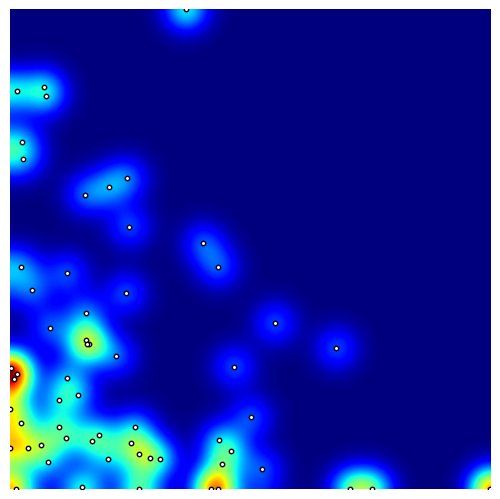

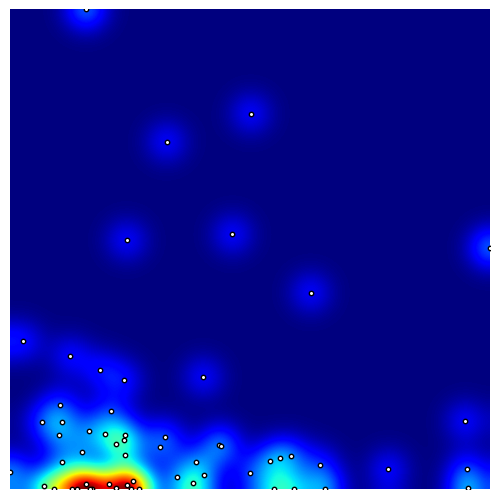

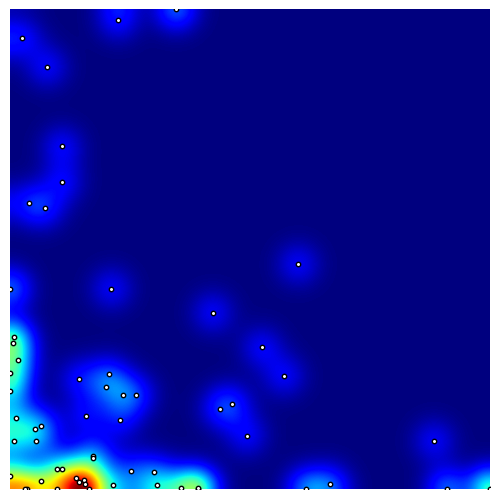

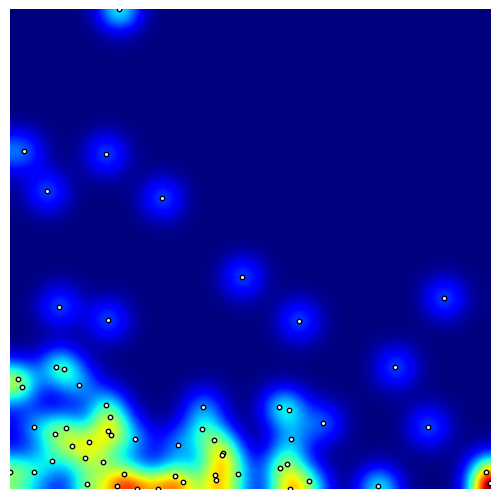

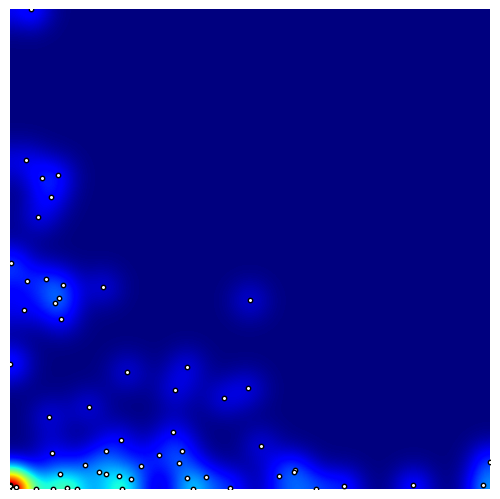

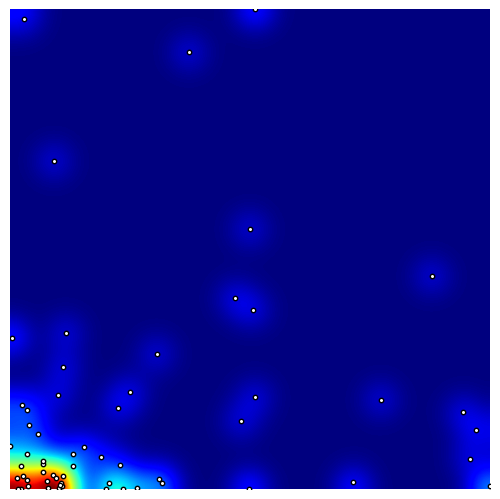

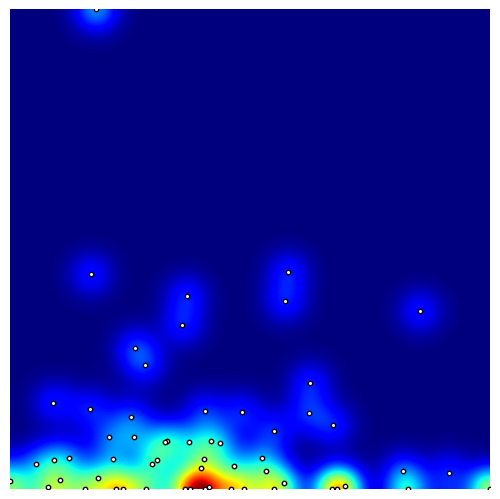

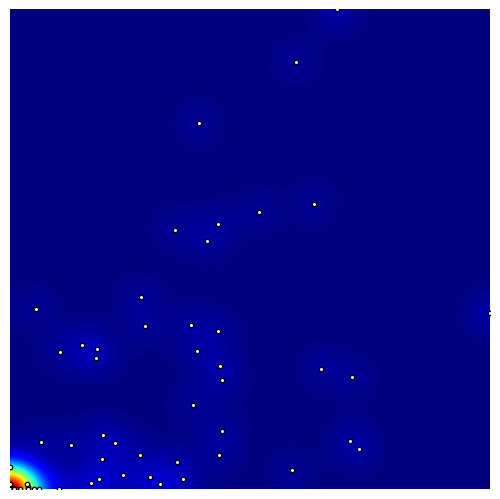

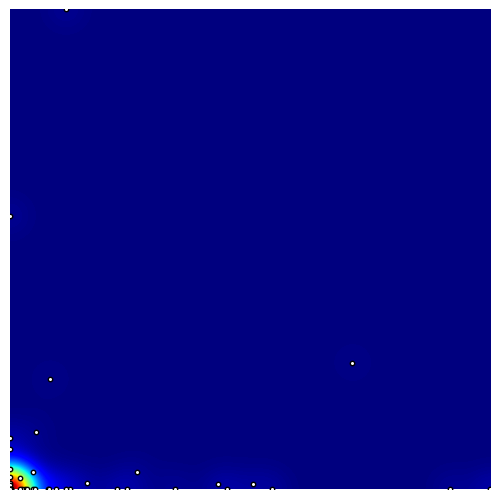

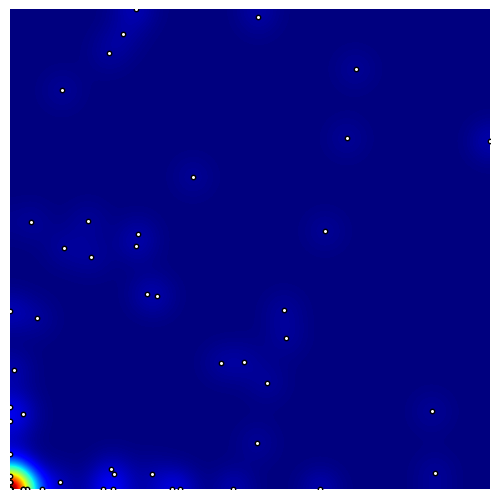

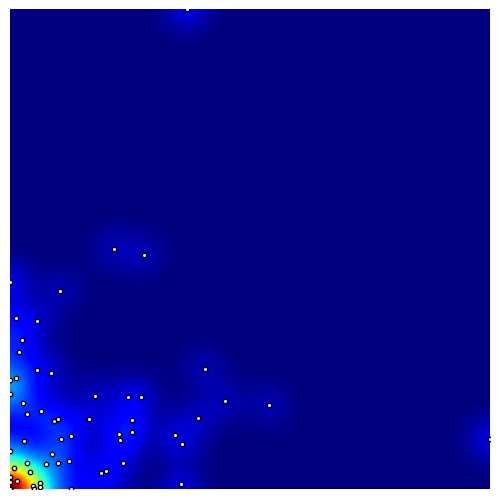

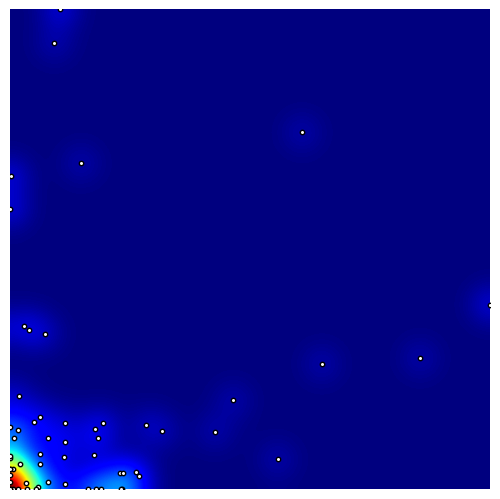

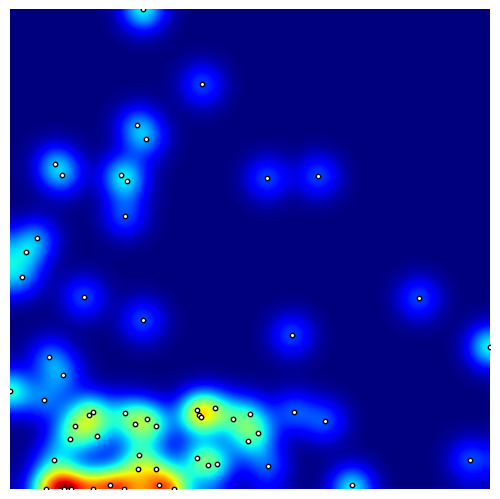

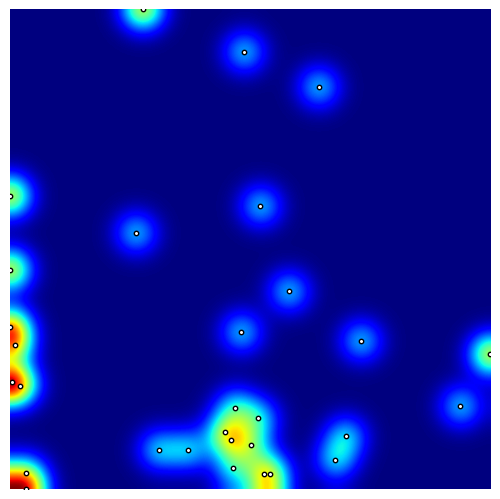

In [15]:
import seaborn as sns

images = []

for group in groups.groupby('group'):
    group_id = group[0]
    subdf = group[1]
    
    # sns.set_style('whitegrid')
    # sns.set_palette('rainbow')
    # sns.set_context('talk')
    # sns.set(rc={'figure.figsize':(5, 5)})
    # sns.set(font_scale=1.5)
    # sns.set_style({'axes.edgecolor': 'black', 'axes.linewidth': 1.0})
    # sns.set_style({'grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.5})
    # sns.set_style({'axes.grid': True, 'axes.facecolor': 'white'})
    
    xtx = subdf['xtx'].values
    xty = subdf['xty'].values
    cluster = subdf['cluster'].values
    
    # convert xtx and xty to heatmap image
    
    
    
    
    # sns.scatterplot(
    #     x=xtx,
    #     y=xty,
    #     hue=cluster,
    #     s=10,
    #     edgecolor='black',
    #     palette='rainbow'
    # )
    # # sns.scatterplot(
    # #     x=model.cluster_centers_[:, 0],
    # #     y=model.cluster_centers_[:, 1],
    # #     color='black',
    # #     s=300,
    # #     marker='x'
    # # )
    # # remove xticks and yticks
    # plt.xticks([])
    # plt.yticks([])

    # # remove legend
    # plt.legend([],[], frameon=False)

    # plt.show()
    
    #fig, ax = plt.subplots()
    #ax.grid(False)
    img, extent = convert_to_heatmap(xtx, xty, 32)

    plt.scatter(
        xtx,
        xty,
        s=10,
        color='white',
        edgecolor='black'
    )
        
    
    plt.axis('off')
    plt.legend([],[], frameon=False)
    plt.grid(False)
    plt.tight_layout(pad=0)
    
    
    
    plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    plt.show()
    
    # disable all axis, legend, grid, and padding
    
    
    # save image
    #plt.savefig(f'./{group_id}.png', bbox_inches='tight', pad_inches=0)

    
    #ax.grid(False)
    #plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet)

In [5]:
from scipy.spatial import Delaunay
#from skimage.transform import warp, AffineTransform

group_ids = groups['group'].unique()
group_ids.sort()
images = [cv2.imread(f'./{id}.png') for id in group_ids]

data = []

for image in images:
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #print(image.shape)
    
    # find landmarks in image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
    corners = np.int0(corners)
    
    
    # use scipy delanay triangulation on the corners
    points = corners.reshape(-1, 2)
    tri = Delaunay(points)
    
    print('total triangles', len(tri.simplices))
    
    data.append((image, points, tri))
    
    # # draw the triangles
    # for triangle in points[tri.simplices]:
    #     cv2.polylines(image, [triangle], True, (255, 0, 0), 1)
    
    
    # for i in corners:
    #     x,y = i.ravel()
    #     cv2.circle(image,(x,y),3,255,-1)

    # plt.imshow(image)
    # plt.show()

# index = 0
# for image, points, tri in data:
    
#     # warp this image to the next image
#     if index + 1 < len(data):
#         warp_image, warp_points, warp_tri = data[index + 1]

        
    
    

total triangles 38
total triangles 44
total triangles 42
total triangles 41
total triangles 39
total triangles 39
total triangles 41
total triangles 43
total triangles 41
total triangles 41
total triangles 42
total triangles 39
total triangles 41
total triangles 41
